In [49]:
# numerical imports
import torch
import numpy as np
# GP imports
from kronecker_structure_models import SVGP2D, VFFGP2D, ASVGPGP2D
# plotting imports
import matplotlib.pyplot as plt
# data imports
from utilsA import gen_2d
# misc imports
from tqdm import tqdm

# Synthetically Generated Data

In [10]:
# data generating function
def squiggly_func_2d(x1, x2):
    return (
        np.sin(5 * x1) + np.cos(7 * x2) +
        0.5 * np.sin(15 * x1) + 0.5 * np.cos(12 * x2) +
        0.2 * np.sin(20 * x1) + 0.2 * np.cos(25 * x2)
    )

In [15]:
# data generating meta
X1LIMS = (0., 1.)
X2LIMS = (0., 1.)
N_OBS = 25 # 25 X 25 = 625 observations
# plotting meta
EXTENT = [X1LIMS[0], X1LIMS[1], X2LIMS[0], X2LIMS[1]]

In [16]:
X, y = gen_2d(squiggly_func_2d, X1LIMS, X2LIMS, N_OBS)

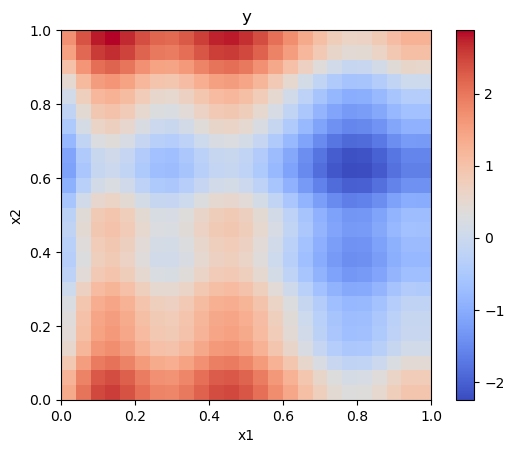

In [22]:
plt.imshow(y.reshape(N_OBS, N_OBS), extent = EXTENT, cmap='coolwarm')
plt.colorbar()
# plot style
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('y');

In [25]:
# training data
X_train = torch.tensor(X, dtype=torch.float64)
y_train = torch.tensor(y.ravel(), dtype=torch.float64)

# SVGP

In [26]:
N_INDUCING = 15 

In [27]:
# inducing points 
Z = torch.tensor(np.random.rand(N_INDUCING, 2), dtype=torch.float64)

In [28]:
# model
sv_gp_2d = SVGP2D(X_train, y_train, Z).to(torch.float64)

In [30]:
# # fit GP
NITER = 100# initialize optimizer
optimizer = torch.optim.Adam(sv_gp_2d.parameters(), lr=0.1)
# perform gradient descent
history = torch.empty(NITER)
for i in tqdm(range(NITER)):
    optimizer.zero_grad()
    elbow = -sv_gp_2d._elbo()
    history[i] = elbow.item()
    elbow.backward()
    optimizer.step()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
100%|██████████| 100/100 [00:08<00:00, 12.12it/s]


# VFF

In [31]:
# frequencies
N_FREQ = 15

In [32]:

vff_gp_2d = VFFGP2D(X_train, y_train, N_FREQ, X1LIMS, X2LIMS).to(torch.float64)

In [33]:
# # fit GP
NITER = 100
optimizer = torch.optim.Adam(vff_gp_2d.parameters(), lr=0.1)
# perform gradient descent
history = torch.empty(NITER)
for i in tqdm(range(NITER)):
    optimizer.zero_grad()
    elbow = -vff_gp_2d._elbo()
    history[i] = elbow.item()
    elbow.backward()
    optimizer.step()

100%|██████████| 100/100 [06:19<00:00,  3.80s/it]


# AVSVGP

In [34]:
# parameters
ASVGPDIM1LIMS = (-1., 2.) # add buffer to the limits to avoid edge effects
ASVGPDIM2LIMS = (-1., 2.) # add buffer to the limits to avoid edge effects
N_KNOTS = 15

In [35]:
asv_gp_2d = ASVGPGP2D(X_train, y_train, N_KNOTS, ASVGPDIM1LIMS, ASVGPDIM2LIMS).to(torch.float64)

In [36]:
# # fit GP
NITER = 100# initialize optimizer
optimizer = torch.optim.Adam(asv_gp_2d.parameters(), lr=0.1)
# perform gradient descent
history = torch.empty(NITER)
for i in tqdm(range(NITER)):
    optimizer.zero_grad()
    elbow = -asv_gp_2d._elbo()
    history[i] = elbow.item()
    elbow.backward()
    optimizer.step()

100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


# Comparison

In [39]:
# get predictions
f_pred_svgp = sv_gp_2d.posterior(X_train)
f_pred_vffgp = vff_gp_2d.posterior(X_train)
f_pred_asvgp = asv_gp_2d.posterior(X_train)

/Users/maxnorman/opt/anaconda3/envs/project_env/lib/python3.9/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")


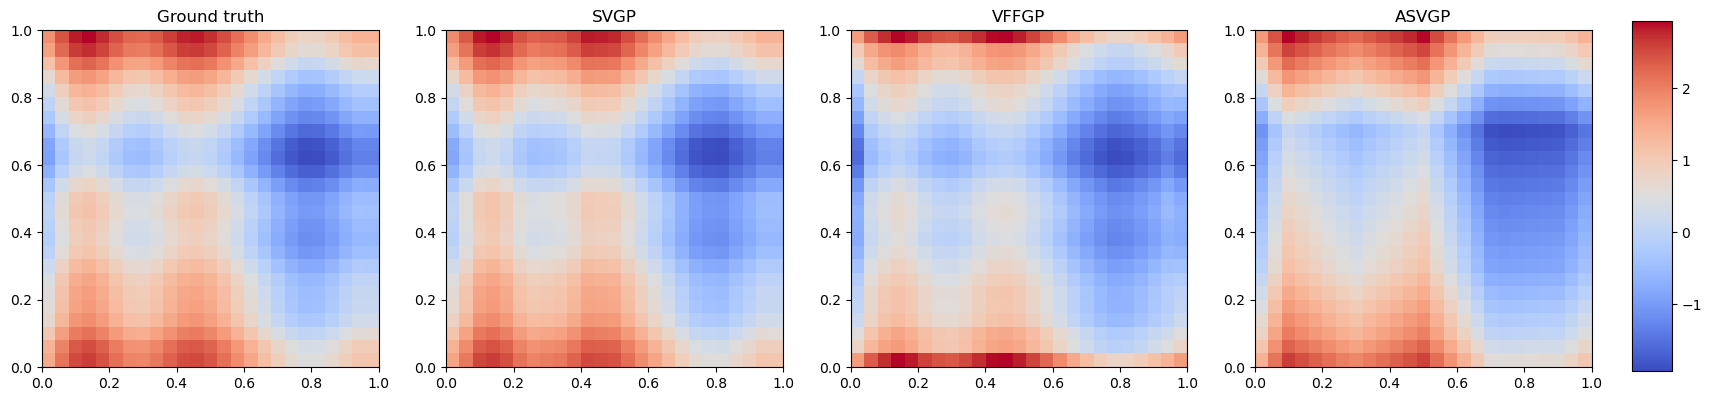

In [48]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

# ground truth
im1 = ax1.imshow(y.reshape(N_OBS, N_OBS), extent = EXTENT, cmap='coolwarm')
ax1.set_title("Ground truth")

# plot SVGP
im2 = ax2.imshow(f_pred_svgp.mean.detach().numpy().reshape(N_OBS, N_OBS), extent = EXTENT, cmap='coolwarm')
ax2.set_title("SVGP")

# plot VFFGP
im3 = ax3.imshow(f_pred_vffgp.mean.detach().numpy().reshape(N_OBS, N_OBS), extent = EXTENT, cmap='coolwarm')
ax3.set_title("VFFGP")

# plot ASVGP
im4 = ax4.imshow(f_pred_asvgp.mean.detach().numpy().reshape(N_OBS, N_OBS), extent = EXTENT, cmap='coolwarm')
ax4.set_title("ASVGP")

# Create a new axis for the colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

# Add the colorbar to the new axis
plt.colorbar(im4, cax=cax)

plt.show()
